Recurrently-connected populations of neurons in the brain exhibit different dynamics, depending on many factors - such as sleep/wake cycles and attended focus. 
These dynamics may be described as being governed by different dynamical regimes, and are thought to position the system to best approximate computations required for a particular context or cognitive state.
Some examples include memory encoding and retrieval in sleep and wake cycles, respectively, and remapping of place cell activity between contexts in the hippocampus.
Given a dynamical systems description, transitions between dynamical regimes are described by bifurcations.
Despite the significance of bifurcations in biological systems, in the machine learning literature, the co-existence of multiple dynamical regimes in recurrent neural networks (RNNs) has received little attention. 

To evaluate the potential benefits of this biological principle in simulation, we can use Nengo to approximate nonlinear dynamical systems in an RNN.
While there are many examples of capturing nonlinear dynamics in Nengo, there are relatively few examples where these systems undergo explicit bifurcations. 
To verify the validity of the Nengo modelling framework for simulating bifurcating nonlinear dynamical systems, in this notebook I build a recurrently-connected network whose dynamics may be described by the Thomas cyclically-symmetric attractor, whose qualitative behavior is specified by a parameter $b$, which is set by an external node.


In [1]:
!pip install scipy

  Using cached numpy-1.25.2-cp39-cp39-win_amd64.whl.metadata (5.7 kB)
Using cached numpy-1.25.2-cp39-cp39-win_amd64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
nengolib 0.5.2 requires nengo<3.0,>=2.2.0, but you have nengo 3.2.0 which is incompatible.
nni 2.6.1 requires numpy<1.19.4; sys_platform == "win32", but you have numpy 1.25.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.25.2 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

import nengo
import nengo_gui.jupyter

In [3]:
def thomas(x,t,b):
    '''
    Defines the vector field associated with Thomas' cyclically symmetric attractor.
    https://en.wikipedia.org/wiki/Thomas%27_cyclically_symmetric_attractor
    
    Args:
        x : state of the system, defined by 3 phase variables
        b : bifurcation parameter controlling the existence and nature of fixed points; 
            corresponds to the dissipativeness of the system.
            
            b > 1     : single stable equilibrium at the origin
            b = 1     : pitchfork bifurcation; two stable fixed points
            b ~ 0.329 : Hopf bifurcation, stable limit cycle
            b ~ 0.208 : chaotic
            b = 0     : ergodic wandering of the space
    '''
    
    x0,x1,x2 = x
    
    dx0 = np.sin(x1) - b*x0
    dx1 = np.sin(x2) - b*x1
    dx2 = np.sin(x0) - b*x2
    
    return [dx0,dx1,dx2]

In [4]:
# specify initial state
x_ = [0.,0.,1.]     # as selected by Kim and Bassett 2023
b = 0.2             # select b to give chaotic behavior
ts = np.linspace(0.,1000.,100000)

xs = odeint( thomas, y0 = x_, t = ts, args = (b,), tcrit = ts )

AttributeError: module 'matplotlib.cbook' has no attribute '_broadcast_with_masks'

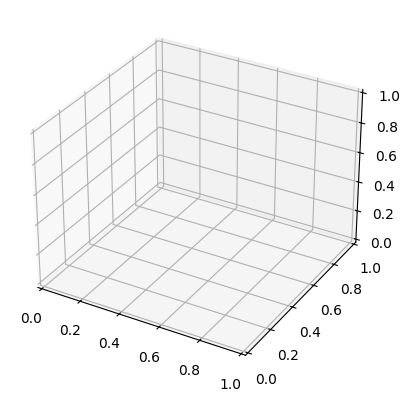

In [5]:
fig,ax = plt.subplots(1,1,subplot_kw = {'projection' : '3d'})
ax.scatter(xs[:,0],xs[:,1],xs[:,2],c = xs[:,2],cmap='inferno',s=1)
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_zlabel(r'$X_3$')
plt.show()

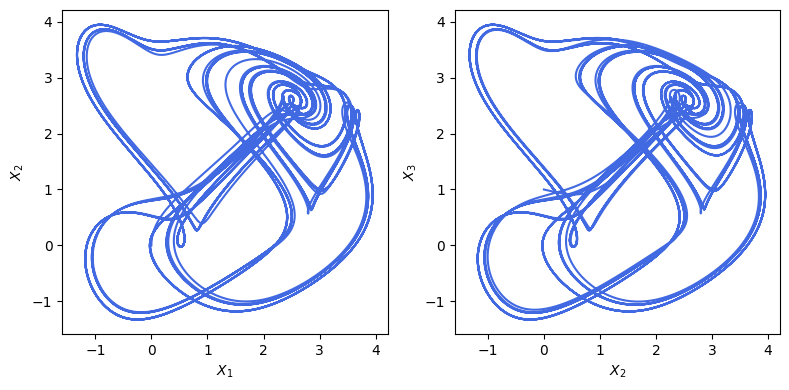

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8.,4.))
ax1.plot(xs[:,0],xs[:,1],color='royalblue')
ax1.set_xlabel(r'$X_1$')
ax1.set_ylabel(r'$X_2$')

ax2.plot(xs[:,1],xs[:,2],color='royalblue')
ax2.set_xlabel(r'$X_2$')
ax2.set_ylabel(r'$X_3$')

fig.tight_layout()
plt.show()

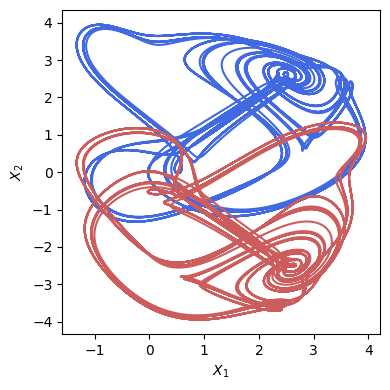

In [7]:
from scipy.spatial.transform import Rotation
def rotate3d( xs, theta ):
    '''
    Rotates 3D data about an axis.
    Args:
        xs     : K x 3 input matrix, where K is number of samples
        theta  : list of angles, in radians, about which to rotate the data
        '''

    R = Rotation.from_euler( 'xyz', theta ).as_matrix()
    
    xs_rotated = xs @ R   
    return xs_rotated

ys = rotate3d( xs, theta = [ 0, 0, np.pi/2 ] )

fig,ax = plt.subplots(1,1,figsize=(4.,4.))
ax.plot(xs[:,0],xs[:,1],color='royalblue')
ax.plot(ys[:,0],ys[:,1],color='indianred')

ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
fig.tight_layout()
plt.show()

In [8]:
# leaning on the velocity-controlled oscillator example from 
tau_synapse = 0.05

def recurrent(x):
    
    x0,x1,x2,b = x
    
    dx0 = np.sin(x1) - b*x0
    dx1 = np.sin(x2) - b*x1
    dx2 = np.sin(x0) - b*x2
    
    return [
            tau_synapse * dx0 + x0, 
            tau_synapse * dx1 + x1, 
            tau_synapse * dx2 + x2, 
            0
        ]

# place cells in legendre space?
with nengo.Network() as model:
    
    # bifurcation parameter of the Thomas attractor
    # b = 0.329 -- stable limit cycle
    b = nengo.Node([0.329])
    
    # recurrently-connected neural population
    ens = nengo.Ensemble( 
        n_neurons = 1000, 
        dimensions = 4,
        radius = 5,
        neuron_type = nengo.RectifiedLinear(),
        )
    
    nengo.Connection( b, ens[3] )
    nengo.Connection( ens, ens, function = recurrent, synapse = tau_synapse )
    
    init = nengo.Node( lambda t: 1. if t < 1. else 0. )
    nengo.Connection( init, ens[2] )

In [ ]:
nengo_gui.jupyter.InlineGUI( model, cfg = 'bifurcations.cfg' )